# CAB420 Linear Regression, Bonus Example: Generalised Linear Models (GLMs)
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview

In linear regression, we have a *linear model* where:
* The response variable (AKA, our output), $y$, is expressed as a linear combination of our predictors (or inputs), $X$;
* The underlying relationship between $y$ and $X$ is linear;
* Our response variable is unbounded, i.e. our output range is $[-\infty...\infty]$; and
* The distribution of the residuals (errors), is Gaussian.

What happens when the above isn't true though? A good example might be trying to predict a count. Perhaps predicting the number of cyclists given some weather conditions. Here, an unbounded output $[-\infty...\infty]$ is clearly not appropriate, and $-\infty$ cyclists is not going to be a good estimation in any circumstances. Ideally, we'd like our model to not even be able to come up with such an answer. 

Generalised Linear Models, as the name implies, *generalise* aspsects of our linear regression so they can be more correctly applied to other scenarios. This means that we can end up with a model that better fits our data, though it does mean that we need to make some additional decisions when setting out model up. Conveniently, GLMs also look a lot like linear regression, which means that they're not that hard to get a handle on from where we're at currently.

### How Does this Connect to the Rest of CAB420?

It very much fits alongside the other stuff that we've looked at with respect to linear regression. A lot of the same things that we looked at with linear regression ($R^2$, p-values, etc) hold here. Regularisation is also an option, and works in the same way.

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt

import statsmodels.api
import statsmodels.formula.api as sm
import scipy.stats as stats

### The Data

We're using the Washington DC bikeshare data again. Here, I'm going to split the data into train and test based on the year. Year 0 (2011) is the training data. Year 1 (2012) is the testing data. Before you complain:
* Yes, I know the number of cyclists increases in the second year, we will underestimate the number of cyclists in the second year and for the purposes of this example I'm fine with it.
* Yes, the training and testing sets about the same size (testing is one day bigger due to the leap year). Yeah, this is odd and not conventional, and for the purposes of this example, it's fine.

In [2]:
data = pandas.read_csv('../data/washingtonbikeshare/day.csv')
data["weekday"] = data["weekday"].astype("category")
data_train = data.loc[data['yr'] == 0]
data_test = data.loc[data['yr'] == 1]

I'm going to create a model with a bunch of higher order terms, and the weekday categorical as well. Throwing this at our least squared regression we get:

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     75.69
Date:                Mon, 29 Aug 2022   Prob (F-statistic):          9.30e-103
Time:                        14:51:24   Log-Likelihood:                -2882.3
No. Observations:                 365   AIC:                             5799.
Df Residuals:                     348   BIC:                             5865.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

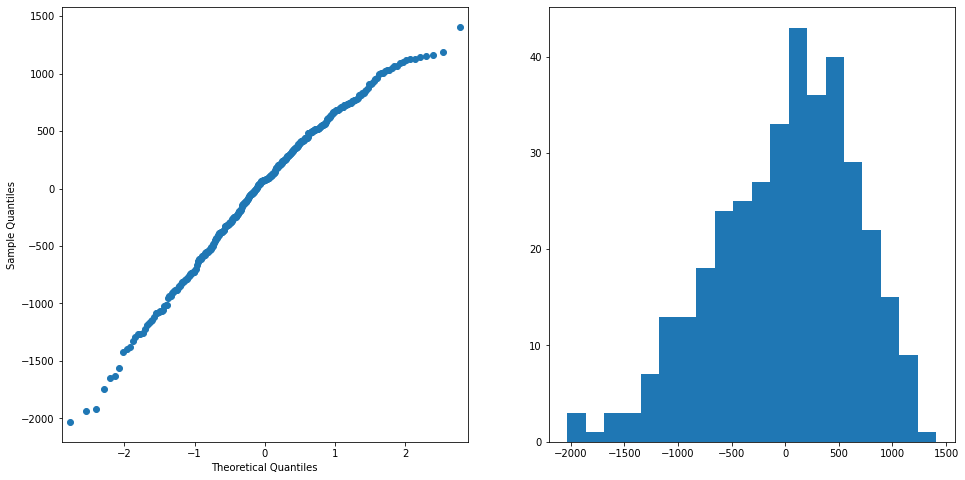

In [3]:
# create the model spec. This will be used for all models.
model_spec = "cnt ~ temp + hum + windspeed + \
              temp*hum + temp*windspeed + hum*windspeed + temp*hum*windspeed + \
              numpy.power(temp, 2.0) + numpy.power(hum, 2.0) + numpy.power(windspeed, 2.0) + \
              weekday"
# fit the model
model = sm.ols(formula=model_spec, data=data_train).fit()
print(model.summary())
fig = plt.figure(figsize=[16, 8])
ax = fig.add_subplot(1, 2, 1)
f = statsmodels.api.qqplot(model.resid, ax=ax)
ax = fig.add_subplot(1, 2, 2)
ax.hist(model.resid, 20);

### What's wrong with this picutre?

We've trained a linear model. From the above:
* We have a number of terms that are not significant, this may be due to terms just being rubbish (i.e. low correlation with the response), or multiple predictors being correlated with each other. Whatever the reason, it's not good.
* Our distribution of residuals looks a bit wonky. There is a bit of skew for one thing.

But this is not all. Let's plot some predictions.

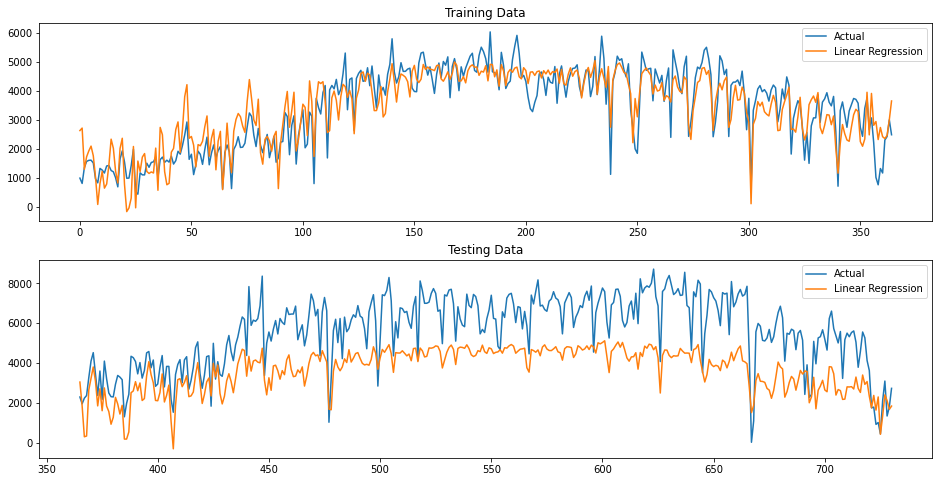

In [4]:
fig = plt.figure(figsize=[16, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(data_train.cnt, label='Actual')
ax.plot(model.predict(data_train), label='Linear Regression')
ax.set_title('Training Data')
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(data_test.cnt, label='Actual')
ax.plot(model.predict(data_test), label='Linear Regression')
ax.set_title('Testing Data')
ax.legend()

There is one other big problem we have, which the more perceptive of you will instantly recognise from the above plot. Those of you blessed with the keen observational skills of a hawk have no doubt just fallen off your chairs with shock, exclaiming *how could this be?!?!*.

For the rest of you, observe:

In [5]:
pred = model.predict(data_test)
print(pred.min())

-306.3569935772747


That's right, on one fateful day, we had a bit under -300 cyclists,

In [6]:
print(pred.argmin())

42


and in an amazing twist of fate this occurred at index 42 (the sceptics among you will claim that I've doctored this data to get this result - I really haven't, this is just the way that it worked out - which is awesome).

#### How, What, Why, Hippo?

Are negative cyclists real? Perhaps these are e-bike riders, people that for all intents appear (at a distance anyway) like cyclists, but are frauds with their silly electric motors and bulky (and ugly) bikes, and have an annoying habbit of passing real cyclists while going uphill without even bothering to pedal (and thus must be immediately chased down and passed to prove a point).

Or, more likely, the model is flawed. What's more, we can create some sort of wintery hell and get even sillier numbers. For our day of doom, we'll set the temperature to 0, humidty to 1 and windspeed to 1. I think this essentially makes it a blizzard.

NOTE: We could set these values to be outside the range of [0..1]. While the data in these columns has been min-max normalised, this does not mean that values outside this range are not possible. Simply anything outside this range would represent a value that is outside the range observed in the dataset. What we've done here is select the coldest observed temperature, the highest observed humidity, and highest observed windspeed. While we could be more extreme, this is still probably a pretty shit day to be outside on a bike.

In [7]:
day_with_horrid_weather = pandas.DataFrame(data_test.iloc[[pred.argmin()]].copy(deep = True))
day_with_horrid_weather['temp'] = 0
day_with_horrid_weather['hum'] = 1
day_with_horrid_weather['windspeed'] = 1
pred = model.predict(day_with_horrid_weather)
print(pred)

407   -9280.757367
dtype: float64


And now we've got a bit under -9000 cyclists (that's a lot of e-bikes).

The reason this occurs is down to a big assumption our model makes - that our output is continuous and **unbounded**. As we can't have a negative number of cyclists, this is clearly not the case. 

#### Is this a problem?

How big of an issue this is depends on your point of view, and the intended use of the model. If, for example, we know that our model is going to be asked to frequently extrapolate and estimate performance is some weird weather conditions, then this is bad. If however, we're just using this to get a rough estimate to maybe anticipate demand and schedule a bit of maintenance, then it's probably not a big deal.

While this might not be "a big deal" in the above example, there's every chance that in a different scenario the ability of our model to estimte things that are not possible could be a deal-breaker. Luckily, we can address that.

## Generalised Linear Models (GLMs)

With a generalised linear model, we can use a linear model to learn a non-linear relationship. We do this by creating a *link* function. Essentially, we learn a linear relationship between our predictors and some transformed version of the response, and map this transformed version, via the link function, to our actual output.

In this way we can predict for example:
* A binary output, 0 or 1, i.e. do classification
* An exponentional output
* A count output (i.e. 0, 1, 2, ....)

While this does give us a lot more freedom than we get with linear regression, it's not a complete free-for-all. We still have the following assumptions/requrements
* Our samples and variables should be independent and random
* The distribution of the response variable, $y$ does is from an exponential family (e.g. binomial, Poisson, multinomial, normal)
* The transformed response variable (i.e. via the link function) is linearly dependent on the independent variables 
* Residuals are independent, but not necessarily normally distributed

### Choosing the Link Function

The link function is the big choice with GLM, and will be guided by the response. In our case with the cyclists, our output is a count. The Poisson distribution is the ideal choice here. The Poisson distribution is a discrete distribution (i.e. only predicts whole numbers) that models the likelihood of a number of events occuring in some fixed interval, assuming that these events occur at a constant rate and independently. This sounds at least roughly like our cyclist count challenge.

We'll now train our GLM. The API for this is very similar to regular linear regression, the only difference is we now need to specify our link function, which we do via the `family` argument. Here. we'll put a Poisson distribution down.

In [8]:
model_glm = sm.glm(formula=model_spec, data=data_train, family=statsmodels.api.families.Poisson()).fit()
print(model_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                  365
Model:                            GLM   Df Residuals:                      348
Model Family:                 Poisson   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26258.
Date:                Mon, 29 Aug 2022   Deviance:                       48917.
Time:                        14:51:25   Pearson chi2:                 4.66e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Looking at the above, we see that:
* The output looks a lot like what we had for the linear model. We have coefficients, p-values, etc. Overall, our p-values look way healthier than they did before.
* We have a Pseudo-$R^2$, which is derived from the $\chi^2$ (chi-squared) value.

Our p-values fill the same role here, and as we have the same assumptions around independent variables we could use the same sort of logic (correlation between predictors, poor p-values) to remove terms. The one place that we'd need to be careful is the relationship between the response and a predictor. We no longer assume a linear relationship between the response and the predictor (only between the *transformed* response), so we can't necessarily use correlation between the response and predictors (though in our case, as our non-linearity comes from the lower bound of $0$ and we're still assuming an approximatley linear relationship for values from $[0..\infty]$, we could still use correlation).

We're not drawing a qq-plot here, as we no longer assume normality for our residuals - so it doesn't make as much sense to test for it.

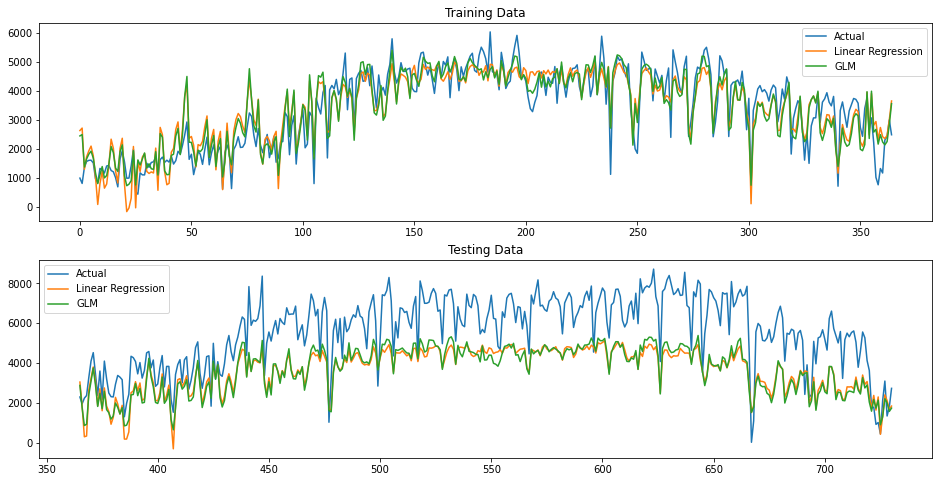

In [9]:
fig = plt.figure(figsize=[16, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(data_train.cnt, label='Actual')
ax.plot(model.predict(data_train), label='Linear Regression')
ax.plot(model_glm.predict(data_train), label='GLM')
ax.set_title('Training Data')
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(data_test.cnt, label='Actual')
ax.plot(model.predict(data_test), label='Linear Regression')
ax.plot(model_glm.predict(data_test), label='GLM')
ax.set_title('Testing Data')
ax.legend()


Looking at our predictions, our model is not suddenly super accurate. This is to be expected, we still have that small issue of the shift in behaviour from one year to the next, this won't solve that problem. Computing some RMSEs confirms this:

In [10]:
def rmse(model, data):
    pred = model.predict(data).to_numpy()
    y_true = data['cnt'].to_numpy()
    return numpy.sqrt(numpy.mean(numpy.power(pred - y_true, 2.0)))

print('Linear Model - RMSE (Train): %1.2f; RMSE (Test): %1.2f' % (rmse(model, data_train), rmse(model, data_test)))
print('GLM          - RMSE (Train): %1.2f; RMSE (Test): %1.2f' % (rmse(model_glm, data_train), rmse(model_glm, data_test)))
print(rmse(model_glm, data_test))

Linear Model - RMSE (Train): 650.52; RMSE (Test): 2184.63
GLM          - RMSE (Train): 608.62; RMSE (Test): 2145.60
2145.597072185136


The GLMs a bit better, but it's not totally awesome. Looking at our minimum value however

In [11]:
pred = model_glm.predict(data_test)
print(pred)
print(pred.min())

365    2874.083301
366    1751.274338
367     862.888436
368     928.204422
369    2408.730516
          ...     
726    1296.428963
727    2206.545499
728    2000.802636
729    1570.610416
730    1737.559803
Length: 366, dtype: float64
647.2077004076398


we see that this now greater than 0. We've removed the possibility of invalid predictions. Even considering our truly horrid winter's day, we also see that the response is still positive.

In [12]:
pred = model_glm.predict(day_with_horrid_weather)
print(pred)

407    1.263088
dtype: float64


## Final Thoughts

Linear regression makes a bunch of assumptions about our data, and the relationships that we're trying to model. A lot of times, these assumptions will not be valid. Sometimes, depending on the application, we might be willing to look past this; other times, the violations may be too extreme, or the consequences too severe to overlook these things. This is where Generalised Linear Models (GLMs) come in. 

With GLMs, we can learn non-linear relationships by using a link function to map between a transformed response and the true response. Essentially we create a linear version of our response and learn a relationship between the data and this, and then map this transformed response to what we're actually trying to preidct. This can be a very powerful tool, and greatly expand what we can do with linear models. We can even add our regluarisation back into GLMs, though we've not shown this here (at the time of writing, this is not implemented in statsmodels, though [pyglmnet](https://glm-tools.github.io/pyglmnet/) may be worth a go if you're keen).